In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm
import pickle
import seaborn as sns
import multiprocessing
import re
from importlib import reload

In [2]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/cper_hls_veg_models/biomass/params')
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/fit')
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/extract')

In [3]:
#reload(sys.modules["cper_bm_params_fit_year_plot_nobai"])
from cper_bm_params_fit_year_transect import *

In [4]:
#reload(sys.modules["hpc_setup"])
from hpc_setup import launch_dask
from ml_setup import fit_ols, fit_dnn

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#client.cluster.close()
#client.close()

In [6]:
if backend == 'dask':
    from hpc_setup import launch_dask
    import psutil
    interface_prefs = [
        'ibp175s0',
        'ibp59s0',
        'enp24s0f0',
        'ens7f0']
    interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
    if len(interface) == 0:
        print('ERROR: Preferred interfaces not found on node!')
    else:
        print(interface)
    num_jobs=32
    client = launch_dask(cluster_loc=cluster_loc,
                         num_jobs=num_jobs,
                         mem_gb_per=4.0,
                         partition='brief-low', 
                         duration='02:00:00',
                         slurm_opts={'interface': interface},
                        wait_timeout=300,
                        debug=False)
    display(client)
    nthreads = len(client.nthreads())
else:
    nthreads = multiprocessing.cpu_count()

ibp175s0
   setting up cluster on HPC...


<Client: 'tcp://10.1.9.223:43633' processes=0 threads=0, memory=0 B>

In [7]:
import torch
if torch.has_cuda and use_cuda:
    device='cuda'
    print(torch.cuda.device_count())
else:
    device='cpu'
print(device)

cpu


In [8]:
#reload(sys.modules["ml_setup"])
from ml_setup import make_model_dictionary
from ml_setup import run_ml_models

In [9]:
mod_dict = make_model_dictionary(var_names, y_col, device)

In [10]:
df = load_df(inPATH, ['Date', 'Date_mean'])

In [11]:
mod_dict['DNN']['fit'] = True
if prefix == 'transect':
    mod_dict['DNN']['param_grid']['batch_size'] =  [256]

In [12]:
if 'BAI_236' not in var_names or 'NDII7' not in var_names or 'NIR1' not in var_names:
    mod_dict['CPER_2022']['fit'] = False
    mod_dict['OLS_2022']['fit'] = False

In [13]:
#client.restart()
#import distributed
#client = [x for x in distributed.client._global_clients.values()][0]
#display(client)
#nthreads = len(client.nthreads())

1
....fitting CPER_2022 (time to fit: 0.13 secs)
....fitting OLS_2022 (time to fit: 0.81 secs)
....fitting OLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:551: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])


(time to fit: 18.37 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.217e+04, tolerance: 1.336e+01
  model = cd_fast.enet_coordinate_descent(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:637: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 12.71 secs)
....fitting PLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.38 secs)
....fitting PCR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:669: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.68 secs)
....fitting SVR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:674: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 41.03 secs)
....fitting RF 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:680: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 46.4 secs)
....fitting GBR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:680: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 59.18 secs)
Skipping MLP, params not set to fit.
....fitting DNN 

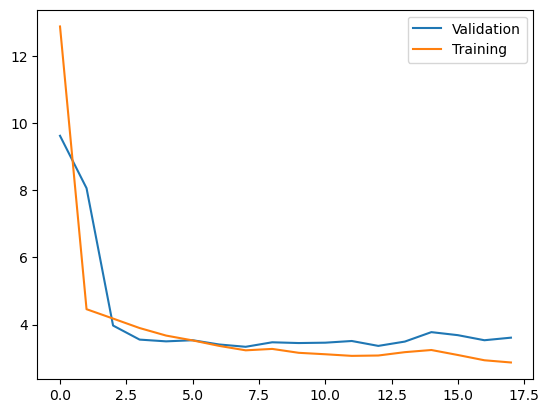

(time to fit: 343.13 secs)
2
....fitting CPER_2022 (time to fit: 0.06 secs)
....fitting OLS_2022 (time to fit: 0.52 secs)
....fitting OLS (time to fit: 8.45 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.921e+02, tolerance: 9.006e+00
  model = cd_fast.enet_coordinate_descent(


(time to fit: 2.32 secs)
....fitting PLS (time to fit: 0.32 secs)
....fitting PCR (time to fit: 0.67 secs)
....fitting SVR (time to fit: 25.7 secs)
....fitting RF (time to fit: 42.17 secs)
....fitting GBR (time to fit: 57.26 secs)
Skipping MLP, params not set to fit.
....fitting DNN 

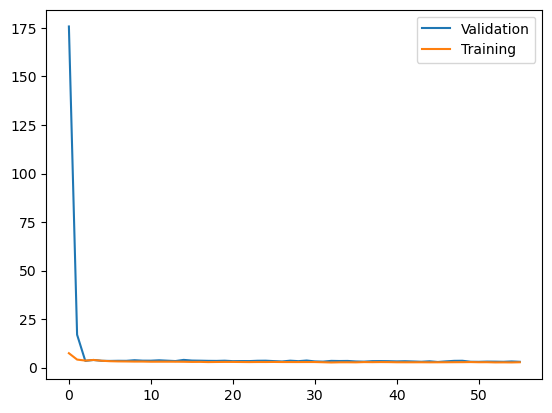

(time to fit: 299.16 secs)
3
....fitting CPER_2022 (time to fit: 0.01 secs)
....fitting OLS_2022 (time to fit: 0.22 secs)
....fitting OLS (time to fit: 8.72 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.117e+03, tolerance: 1.491e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 2.63 secs)
....fitting PLS (time to fit: 0.35 secs)
....fitting PCR (time to fit: 0.46 secs)
....fitting SVR (time to fit: 74.59 secs)
....fitting RF (time to fit: 49.14 secs)
....fitting GBR (time to fit: 97.54 secs)
Skipping MLP, params not set to fit.
....fitting DNN 

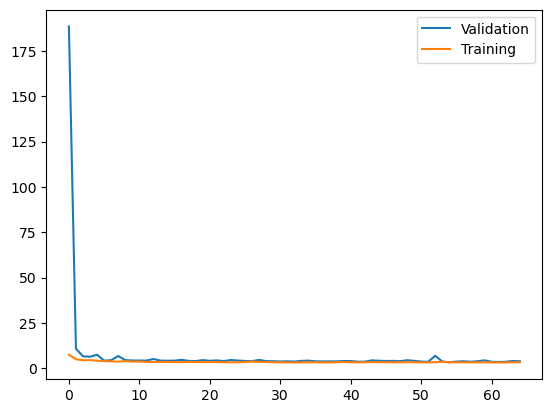

(time to fit: 640.89 secs)
4
....fitting CPER_2022 (time to fit: 0.05 secs)
....fitting OLS_2022 (time to fit: 0.42 secs)
....fitting OLS (time to fit: 8.97 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.139e+03, tolerance: 1.442e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 2.9 secs)
....fitting PLS (time to fit: 0.37 secs)
....fitting PCR (time to fit: 0.57 secs)
....fitting SVR (time to fit: 83.67 secs)
....fitting RF (time to fit: 51.16 secs)
....fitting GBR (time to fit: 87.37 secs)
Skipping MLP, params not set to fit.
....fitting DNN 

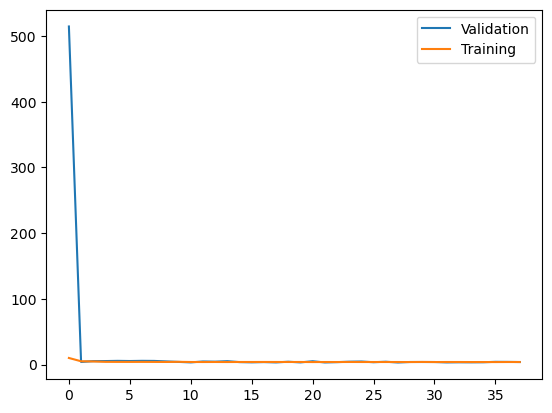

(time to fit: 637.81 secs)
5
....fitting CPER_2022 (time to fit: 0.05 secs)
....fitting OLS_2022 (time to fit: 0.34 secs)
....fitting OLS (time to fit: 8.89 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.171e+03, tolerance: 1.291e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 2.65 secs)
....fitting PLS (time to fit: 0.4 secs)
....fitting PCR (time to fit: 0.45 secs)
....fitting SVR (time to fit: 54.25 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 58.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 46.59 secs)
....fitting GBR (time to fit: 84.84 secs)
Skipping MLP, params not set to fit.
....fitting DNN 

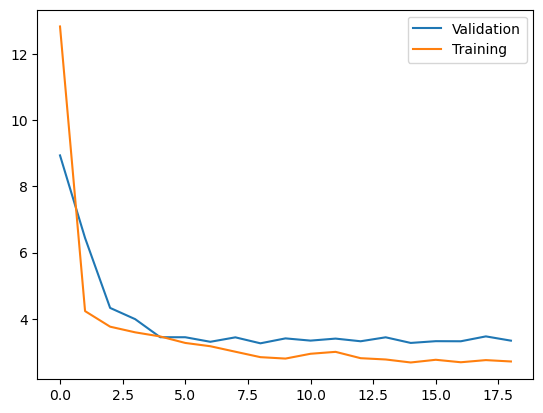

(time to fit: 395.02 secs)


In [14]:
run_ml_models(nickname,
              mod_dict,
              df, 
              y_col,
              date_col,
              var_names,
              kfold_group,
              tuneby_group, 
              kfold_type,
              tune_kfold_type,
              outFILE_tmp, 
              outDIR,
              backend,
              nthreads,
              cper_mod_xfrm,
              cper_mod_xfrm_func,
             client)